# Opdracht week 8 (laatste opdracht)
Importeren van de benodigde packages

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

We gaan gebruik maken van het `vw.csv` bestand welke de volgende kolommen bevat:

- `model`: het model van de auto
- `year`: het bouwjaar van de auto
- `price`: de prijs van de auto in ponden
- `transmission`: het type transmissie van de auto
- `mileage`: het aantal gereden kilometers met de auto
- `fuelType`: het type brandstof van de auto
- `tax`: de wegenbelasting van de auto
- `mpg`: het aantal mijlen dat de auto kan rijden op 1 gallon brandstof
- `engineSize`: de grootte van de motor van de auto

Deze dataset is afkomstig van [Kaggle](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes) en bevat informatie over tweedehands auto's van het merk Volkswagen welke in het Verenigd Koninkrijk te koop staan.

In [2]:
data = pd.read_csv('vw.csv')

data.head(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,T-Roc,2019,25000,Automatic,13904,Diesel,145,49.6,2.0
1,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0
2,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0
3,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5
5,T-Roc,2020,31895,Manual,10,Petrol,145,42.2,1.5
6,T-Roc,2020,27895,Manual,10,Petrol,145,42.2,1.5
7,T-Roc,2020,39495,Semi-Auto,10,Petrol,145,32.5,2.0
8,T-Roc,2019,21995,Manual,10,Petrol,145,44.1,1.0
9,T-Roc,2019,23285,Manual,10,Petrol,145,42.2,1.5


Definiëren van de X en y variabelen en spitten van de dataset in een train en test set.

In [3]:
X = data[['model', 'year', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize']]
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)

We creëren een preprocessing pipeline voor de numerieke variabelen en de categorische variabelen om de data klaar te maken voor het trainen van het model.  
We gebruiken `OneHotEncoder` voor de categorische variabelen en `StandardScaler` voor de numerieke variabelen.  
Met `ColumnTransformer` kunnen verschillende kolommen van de invoer afzonderlijk worden getransformeerd en de features die door elke transformator worden gegenereerd, worden samengevoegd tot een enkele feature space.

In [4]:
categorical_cols = ['model', 'transmission', 'fuelType']
numerical_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

Voor het trainen van het model maken we gebruik van `RandomForestRegressor`.  
Random Forest is een ensemble-leermethode die meerdere beslisbomen combineert om voorspellingen te doen. Het is bijzonder effectief voor regressietaken zoals het voorspellen van autoprijzen, omdat het complexe relaties tussen kenmerken en doelvariabelen kan vastleggen. In dit geval is de doelvariabele de prijs van de auto.

In [5]:
model = RandomForestRegressor(random_state=314)

Vanaf dit punt gaan we de pipeline opzetten voor het trainen van het model. Dit is een simpele pipeline waar we de preprocessing uitvoeren en vervolgens het model trainen.

In [6]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

Hyperparameter tuning is een belangrijk onderdeel van het trainen van een model. We gaan gebruik maken van `GridSearchCV` om de beste hyperparameters te vinden voor het trainen van het model. Hiervoor hebben we een selectie gemaakt van de hyperparameters die we willen testen. Deze zijn hieronder gedefinieerd. En deze worden vervolgens ook alvast ge-fit op de pipeline en daar rollen de beste hyperparameters van de selectie uit.

In [7]:
param_grid = {
    'model__n_estimators': [20, 50, 100, 200, 300],
    'model__max_depth': [5, 10, 20, 30]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'model__max_depth': 20, 'model__n_estimators': 300}


Tot slot gaan we kijken naar de performance van dit model met de berekende beste hyperparameters. We kijken naar de MAE (Mean Absolute Error) en de R-squared ($R^2$) score. Dit doen we op de test set omdat deze nog niet gezien is door het model.

In [8]:
# Predict on the test data
y_pred = grid_search.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'R-squared (R2) Score: {r2}')

Mean Absolute Error: 1030.2166821550925
R-squared (R2) Score: 0.9568583631242776


Laten we de verschillen tussen de voorspelde waarden en de werkelijke waarden eens plotten in een grafiek. We plotten de eerste 100 waarden van de test set.

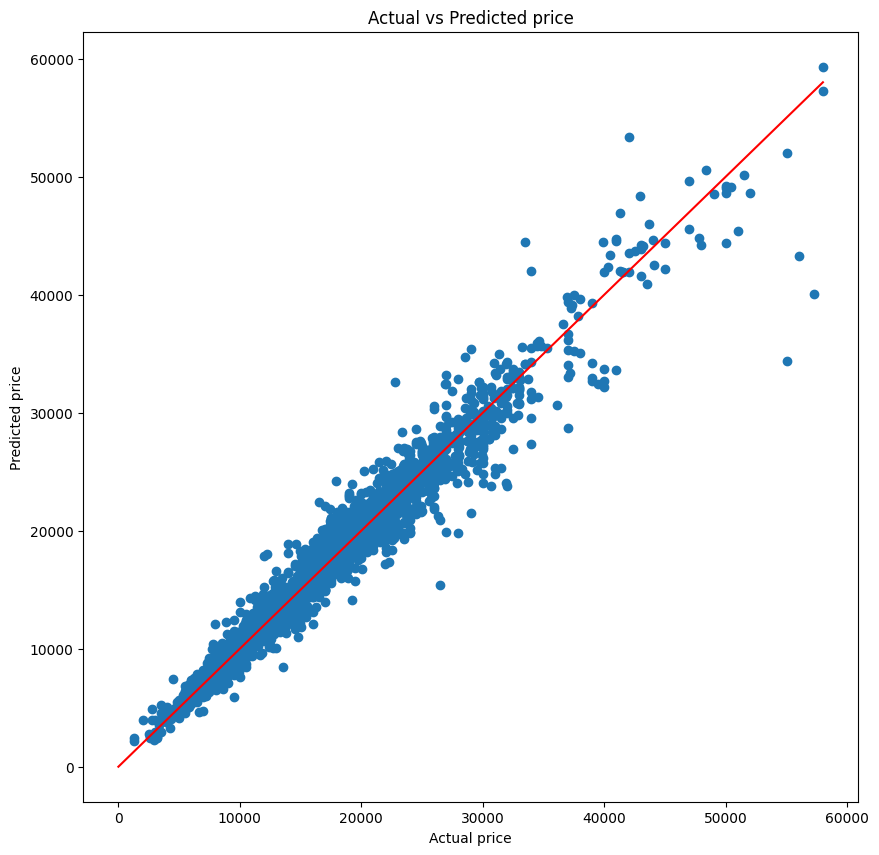

In [9]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red')
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual vs Predicted price')
plt.show()

Hier is duidelijk te zien dat de daadwerkelijke waarden en de voorspelde waarden dicht bij elkaar liggen. Dit bevestigd de vermoedens die we hadden bij het bekijken van de MAE en de $R^2$ score. Al valt het wel op dat er bij hogere prijzen meer afwijkingen zijn tussen de voorspelde waarden en de werkelijke waarden, dit is te verklaren doordat er minder data is met hogere prijzen.